<div style="position: relative; display: flex; align-items: center; justify-content: space-between;">
    <div>
        <b>MSE: TSM_MarkFor | FS 2025</b><br>
        <a href="mailto:daniel.kogan@stud.hslu.ch">Daniel Kogan</a> | 
        <a href="mailto:sven.traeger@stud.hslu.ch">Sven Träger</a> | 
        <i>Date: 01.05.2025</i>
    </div>
</div>

<h1>Optimization of Beverage Sales</h1>
<hr style="border: 1px solid black;">

### Load necessary libraries

In [1]:
library(tidyverse) # includes ggplot2, dplyr, tidyr, purrr
library(lubridate)
library(skimr)
library(janitor)
library(knitr)
library(rfm)
library(caret)
library(jtools)
library(broom)
library(Metrics)
library(scales)

Warning message:
"Paket 'tidyverse' wurde unter R Version 4.4.3 erstellt"
Warning message:
"Paket 'tidyr' wurde unter R Version 4.4.3 erstellt"
Warning message:
"Paket 'readr' wurde unter R Version 4.4.3 erstellt"
Warning message:
"Paket 'dplyr' wurde unter R Version 4.4.3 erstellt"
Warning message:
"Paket 'forcats' wurde unter R Version 4.4.3 erstellt"
Warning message:
"Paket 'lubridate' wurde unter R Version 4.4.3 erstellt"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"Paket 'skimr' wurde unter R 

### Load dataset

In [2]:
df <- read_csv("synthetic_beverage_sales_data.csv", show_col_types = FALSE) %>%
  clean_names()
head(df, 4) # print first 4 rows of data frame
glimpse(df) # print summary of data frame

order_id,customer_id,customer_type,product,category,unit_price,quantity,discount,total_price,region,order_date
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<date>
ORD1,CUS1496,B2B,Vio Wasser,Water,1.66,53,0.10,79.18,Baden-Württemberg,2023-08-23
ORD1,CUS1496,B2B,Evian,Water,1.56,90,0.10,126.36,Baden-Württemberg,2023-08-23
ORD1,CUS1496,B2B,Sprite,Soft Drinks,1.17,73,0.05,81.14,Baden-Württemberg,2023-08-23
ORD1,CUS1496,B2B,Rauch Multivitamin,Juices,3.22,59,0.10,170.98,Baden-Württemberg,2023-08-23


Rows: 8,999,910
Columns: 11
$ order_id      <chr> "ORD1", "ORD1", "ORD1", "ORD1", "ORD1", "ORD2", "ORD3", …
$ customer_id   <chr> "CUS1496", "CUS1496", "CUS1496", "CUS1496", "CUS1496", "…
$ customer_type <chr> "B2B", "B2B", "B2B", "B2B", "B2B", "B2C", "B2B", "B2B", …
$ product       <chr> "Vio Wasser", "Evian", "Sprite", "Rauch Multivitamin", "…
$ category      <chr> "Water", "Water", "Soft Drinks", "Juices", "Water", "Alc…
$ unit_price    <dbl> 1.66, 1.56, 1.17, 3.22, 0.87, 9.09, 2.14, 0.43, 1.21, 1.…
$ quantity      <dbl> 53, 90, 73, 59, 35, 2, 44, 13, 92, 3, 11, 8, 16, 3, 43, …
$ discount      <dbl> 0.10, 0.10, 0.05, 0.10, 0.10, 0.00, 0.10, 0.05, 0.10, 0.…
$ total_price   <dbl> 79.18, 126.36, 81.14, 170.98, 27.40, 18.18, 84.74, 5.31,…
$ region        <chr> "Baden-Württemberg", "Baden-Württemberg", "Baden-Württem…
$ order_date    <date> 2023-08-23, 2023-08-23, 2023-08-23, 2023-08-23, 2023-08…


### Data Preperation

In [3]:
df[df == ""] <- NA # Replace empty strings with NA

colSums(is.na(df)) # Check for missing values

sum(duplicated(df)) # Check for duplicate entries

df %>% # Count rows with invalid or implausible values
  filter(
    unit_price <= 0 | # Unit price should be greater than 0
      quantity <= 0 | # Quantity should be greater than 0
      discount < 0 | discount > 1 | # Discount must be between 0 and 1
      total_price < 0 # Total price should not be negative
  ) %>%
  nrow() # Count number of rows that meet any of the above conditions

order_id   customer_id customer_type       product      category 
            0             0             0             0             0 
   unit_price      quantity      discount   total_price        region 
            0             0             0             0             0 
   order_date 
            0

[1] 0

[1] 0

### Splitting into B2B and B2C & grouping into different dataframes:
#### line-wise, rfm-base, numeric-invoice-wise, full-invoice-wise

In [4]:
# Split into B2B and B2C segments
# Each row represents a product purchase/position(line item)
# by a customer on a specific day.
# A customer may appear multiple times per day for different products.

# B2B orders
line_wise_b2b <- df %>% filter(customer_type == "B2B")
# B2C orders
line_wise_b2c <- df %>% filter(customer_type == "B2C")

# Required for RFM: only customer_id, order_date, and revenue

# B2B orders
rfm_base_b2b <- line_wise_b2b %>%
  group_by(customer_id, order_date) %>% # Group by customer and date
  summarise(
    total_price = sum(total_price, na.rm = TRUE), # Total revenue per order
    .groups = "drop"
  )
# B2C orders
rfm_base_b2c <- line_wise_b2c %>%
  group_by(customer_id, order_date) %>%
  summarise(
    total_price = sum(total_price, na.rm = TRUE),
    .groups = "drop"
  )

# Numerical summary per invoice (for statistical modeling)
# One row per customer and date = one invoice

# B2B orders
numeric_invoice_wise_b2b <- line_wise_b2b %>%
  group_by(customer_id, order_date) %>%
  summarise(
    quantity = sum(quantity, na.rm = TRUE),
    discount = mean(discount, na.rm = TRUE), # Avg. discount per invoice
    unit_price = mean(unit_price, na.rm = TRUE), # Avg. unit price per invoice
    total_price = sum(total_price, na.rm = TRUE), # Total invoice value
    .groups = "drop"
  )
# B2C orders
numeric_invoice_wise_b2c <- line_wise_b2c %>%
  group_by(customer_id, order_date) %>%
  summarise(
    quantity = sum(quantity, na.rm = TRUE),
    discount = mean(discount, na.rm = TRUE),
    unit_price = mean(unit_price, na.rm = TRUE),
    total_price = sum(total_price, na.rm = TRUE),
    .groups = "drop"
  )

# Full invoice-level dataset including order_id and region
# Each row = one invoice (combination of order_id, customer_id, and date)

# B2B orders
full_invoice_wise_b2b <- line_wise_b2b %>%
  group_by(order_id, customer_id, order_date, region) %>%
  summarise(
    quantity = sum(quantity, na.rm = TRUE),
    discount = mean(discount, na.rm = TRUE),
    unit_price = mean(unit_price, na.rm = TRUE),
    total_price = sum(total_price, na.rm = TRUE),
    .groups = "drop"
  )
# B2C orders
full_invoice_wise_b2c <- line_wise_b2c %>%
  group_by(order_id, customer_id, order_date, region) %>%
  summarise(
    quantity = sum(quantity, na.rm = TRUE),
    discount = mean(discount, na.rm = TRUE),
    unit_price = mean(unit_price, na.rm = TRUE),
    total_price = sum(total_price, na.rm = TRUE),
    .groups = "drop"
  )


In [5]:
# ------------------------------ prints ------------------------------
print("line-wise, b2b")
glimpse(line_wise_b2b) # print summary of data frame
head(line_wise_b2b, 4) # print first 4 rows of data frame

print("rfm-base, b2b")
glimpse(rfm_base_b2b) # print summary of data frame
head(rfm_base_b2b, 4) # print first 4 rows of data frame

print("numeric-invoice-wise, b2b")
glimpse(numeric_invoice_wise_b2b) # print summary of data frame
head(numeric_invoice_wise_b2b, 4) # print first 4 rows of data frame

print("full-invoice-wise, b2b")
glimpse(full_invoice_wise_b2b) # print summary of data frame
head(full_invoice_wise_b2b, 4) # print first 4 rows of data frame

[1] "line-wise, b2b"


Rows: 3,204,505
Columns: 11
$ order_id      <chr> "ORD1", "ORD1", "ORD1", "ORD1", "ORD1", "ORD3", "ORD3", …
$ customer_id   <chr> "CUS1496", "CUS1496", "CUS1496", "CUS1496", "CUS1496", "…
$ customer_type <chr> "B2B", "B2B", "B2B", "B2B", "B2B", "B2B", "B2B", "B2B", …
$ product       <chr> "Vio Wasser", "Evian", "Sprite", "Rauch Multivitamin", "…
$ category      <chr> "Water", "Water", "Soft Drinks", "Juices", "Water", "Jui…
$ unit_price    <dbl> 1.66, 1.56, 1.17, 3.22, 0.87, 2.14, 0.43, 1.21, 1.38, 1.…
$ quantity      <dbl> 53, 90, 73, 59, 35, 44, 13, 92, 3, 8, 16, 3, 43, 44, 10,…
$ discount      <dbl> 0.10, 0.10, 0.05, 0.10, 0.10, 0.10, 0.05, 0.10, 0.05, 0.…
$ total_price   <dbl> 79.18, 126.36, 81.14, 170.98, 27.40, 84.74, 5.31, 100.19…
$ region        <chr> "Baden-Württemberg", "Baden-Württemberg", "Baden-Württem…
$ order_date    <date> 2023-08-23, 2023-08-23, 2023-08-23, 2023-08-23, 2023-08…


order_id,customer_id,customer_type,product,category,unit_price,quantity,discount,total_price,region,order_date
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<date>
ORD1,CUS1496,B2B,Vio Wasser,Water,1.66,53,0.10,79.18,Baden-Württemberg,2023-08-23
ORD1,CUS1496,B2B,Evian,Water,1.56,90,0.10,126.36,Baden-Württemberg,2023-08-23
ORD1,CUS1496,B2B,Sprite,Soft Drinks,1.17,73,0.05,81.14,Baden-Württemberg,2023-08-23
ORD1,CUS1496,B2B,Rauch Multivitamin,Juices,3.22,59,0.10,170.98,Baden-Württemberg,2023-08-23


[1] "rfm-base, b2b"
Rows: 935,300
Columns: 3
$ customer_id <chr> "CUS1000", "CUS1000", "CUS1000", "CUS1000", "CUS1000", "CU…
$ order_date  <date> 2021-01-03, 2021-01-04, 2021-01-06, 2021-01-11, 2021-01-1…
$ total_price <dbl> 827.07, 414.21, 142.12, 348.41, 1051.40, 570.97, 4350.27, …


customer_id,order_date,total_price
<chr>,<date>,<dbl>
CUS1000,2021-01-03,827.07
CUS1000,2021-01-04,414.21
CUS1000,2021-01-06,142.12
CUS1000,2021-01-11,348.41


[1] "numeric-invoice-wise, b2b"
Rows: 935,300
Columns: 6
$ customer_id <chr> "CUS1000", "CUS1000", "CUS1000", "CUS1000", "CUS1000", "CU…
$ order_date  <date> 2021-01-03, 2021-01-04, 2021-01-06, 2021-01-11, 2021-01-1…
$ quantity    <dbl> 228, 144, 22, 130, 241, 139, 107, 297, 30, 65, 293, 163, 1…
$ discount    <dbl> 0.08750000, 0.06250000, 0.05000000, 0.12500000, 0.08000000…
$ unit_price  <dbl> 2.887500, 2.522500, 6.800000, 2.435000, 4.976000, 5.104000…
$ total_price <dbl> 827.07, 414.21, 142.12, 348.41, 1051.40, 570.97, 4350.27, …


customer_id,order_date,quantity,discount,unit_price,total_price
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
CUS1000,2021-01-03,228,0.0875,2.8875,827.07
CUS1000,2021-01-04,144,0.0625,2.5225,414.21
CUS1000,2021-01-06,22,0.0500,6.8000,142.12
CUS1000,2021-01-11,130,0.1250,2.4350,348.41


[1] "full-invoice-wise, b2b"
Rows: 1,068,808
Columns: 8
$ order_id    <chr> "ORD1", "ORD10", "ORD1000", "ORD1000000", "ORD1000006", "O…
$ customer_id <chr> "CUS1496", "CUS9472", "CUS9185", "CUS3347", "CUS3145", "CU…
$ order_date  <date> 2023-08-23, 2023-04-09, 2022-06-17, 2023-07-07, 2021-01-2…
$ region      <chr> "Baden-Württemberg", "Bayern", "Niedersachsen", "Thüringen…
$ quantity    <dbl> 310, 196, 161, 184, 75, 167, 11, 244, 359, 218, 340, 380, …
$ discount    <dbl> 0.09000000, 0.08333333, 0.08750000, 0.08333333, 0.10000000…
$ unit_price  <dbl> 1.696000, 1.820000, 6.480000, 30.736667, 1.430000, 1.98666…
$ total_price <dbl> 485.06, 301.74, 1018.33, 6293.73, 96.52, 370.17, 18.29, 22…


order_id,customer_id,order_date,region,quantity,discount,unit_price,total_price
<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ORD1,CUS1496,2023-08-23,Baden-Württemberg,310,0.09000000,1.69600,485.06
ORD10,CUS9472,2023-04-09,Bayern,196,0.08333333,1.82000,301.74
ORD1000,CUS9185,2022-06-17,Niedersachsen,161,0.08750000,6.48000,1018.33
ORD1000000,CUS3347,2023-07-07,Thüringen,184,0.08333333,30.73667,6293.73


### Descriptive Statistical Analysis

In [6]:
# Summary statistics based on line-item level (each row = one product purchase)
# Not aggregated by invoice/customer

# B2B orders
line_wise_summary_b2b <- line_wise_b2b %>%
  summarise(
    discount    = list(discount),
    quantity    = list(quantity),
    total_price = list(total_price),
    unit_price  = list(unit_price)
  ) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "values") %>%
  mutate(
    count  = map_int(values, ~ length(.x)),
    mean   = map_dbl(values, ~ mean(.x, na.rm = TRUE)),
    sd     = map_dbl(values, ~ sd(.x, na.rm = TRUE)),
    min    = map_dbl(values, ~ min(.x, na.rm = TRUE)),
    q25    = map_dbl(values, ~ quantile(.x, 0.25, na.rm = TRUE)),
    median = map_dbl(values, ~ median(.x, na.rm = TRUE)),
    q75    = map_dbl(values, ~ quantile(.x, 0.75, na.rm = TRUE)),
    max    = map_dbl(values, ~ max(.x, na.rm = TRUE))
  ) %>%
  select(variable, count, mean, sd, min, q25, median, q75, max)
# B2C orders
line_wise_summary_b2c <- line_wise_b2c %>%
  summarise(
    discount    = list(discount),
    quantity    = list(quantity),
    total_price = list(total_price),
    unit_price  = list(unit_price)
  ) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "values") %>%
  mutate(
    count  = map_int(values, ~ length(.x)),
    mean   = map_dbl(values, ~ mean(.x, na.rm = TRUE)),
    sd     = map_dbl(values, ~ sd(.x, na.rm = TRUE)),
    min    = map_dbl(values, ~ min(.x, na.rm = TRUE)),
    q25    = map_dbl(values, ~ quantile(.x, 0.25, na.rm = TRUE)),
    median = map_dbl(values, ~ median(.x, na.rm = TRUE)),
    q75    = map_dbl(values, ~ quantile(.x, 0.75, na.rm = TRUE)),
    max    = map_dbl(values, ~ max(.x, na.rm = TRUE))
  ) %>%
  select(variable, count, mean, sd, min, q25, median, q75, max)

# Summary statistics based on invoice-level data
# Each row represents one invoice (aggregated per customer and order date)

# B2B orders
invoice_wise_summary_b2b <- numeric_invoice_wise_b2b %>%
  summarise(
    discount    = list(discount),
    quantity    = list(quantity),
    total_price = list(total_price),
    unit_price  = list(unit_price)
  ) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "values") %>%
  mutate(
    count  = map_int(values, ~ length(.x)),
    mean   = map_dbl(values, ~ mean(.x, na.rm = TRUE)),
    sd     = map_dbl(values, ~ sd(.x, na.rm = TRUE)),
    min    = map_dbl(values, ~ min(.x, na.rm = TRUE)),
    q25    = map_dbl(values, ~ quantile(.x, 0.25, na.rm = TRUE)),
    median = map_dbl(values, ~ median(.x, na.rm = TRUE)),
    q75    = map_dbl(values, ~ quantile(.x, 0.75, na.rm = TRUE)),
    max    = map_dbl(values, ~ max(.x, na.rm = TRUE))
  ) %>%
  select(variable, count, mean, sd, min, q25, median, q75, max)
# B2C orders
invoice_wise_summary_b2c <- numeric_invoice_wise_b2c %>%
  summarise(
    discount    = list(discount),
    quantity    = list(quantity),
    total_price = list(total_price),
    unit_price  = list(unit_price)
  ) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "values") %>%
  mutate(
    count  = map_int(values, ~ length(.x)),
    mean   = map_dbl(values, ~ mean(.x, na.rm = TRUE)),
    sd     = map_dbl(values, ~ sd(.x, na.rm = TRUE)),
    min    = map_dbl(values, ~ min(.x, na.rm = TRUE)),
    q25    = map_dbl(values, ~ quantile(.x, 0.25, na.rm = TRUE)),
    median = map_dbl(values, ~ median(.x, na.rm = TRUE)),
    q75    = map_dbl(values, ~ quantile(.x, 0.75, na.rm = TRUE)),
    max    = map_dbl(values, ~ max(.x, na.rm = TRUE))
  ) %>%
  select(variable, count, mean, sd, min, q25, median, q75, max)

In [7]:
# ------------------------------ Print summary tables ------------------------------
kable(line_wise_summary_b2b, caption = "Line-wise summary statistics of B2B numeric variables", digits = 2)
kable(line_wise_summary_b2c, caption = "Line-wise summary statistics of B2C numeric variables", digits = 2)
kable(invoice_wise_summary_b2b, caption = "Invoice-level summary statistics of B2B orders", digits = 2)
kable(invoice_wise_summary_b2c, caption = "Invoice-level summary statistics of B2C orders", digits = 2)




Table: Line-wise summary statistics of B2B numeric variables

|variable    |   count|   mean|     sd|  min|   q25| median|    q75|      max|
|:-----------|-------:|------:|------:|----:|-----:|------:|------:|--------:|
|discount    | 3204505|   0.08|   0.03| 0.05|  0.05|   0.10|   0.10|     0.15|
|quantity    | 3204505|  50.52|  28.87| 1.00| 26.00|  51.00|  76.00|   100.00|
|total_price | 3204505| 281.36| 810.75| 0.30| 31.35|  77.20| 167.58| 14295.30|
|unit_price  | 3204505|   5.63|  13.21| 0.32|  1.03|   1.81|   3.04|   169.53|



Table: Line-wise summary statistics of B2C numeric variables

|variable    |   count|  mean|     sd|  min|  q25| median|   q75|     max|
|:-----------|-------:|-----:|------:|----:|----:|------:|-----:|-------:|
|discount    | 5795405|  0.00|   0.00| 0.00| 0.00|   0.00|  0.00|    0.00|
|quantity    | 5795405|  8.00|   4.32| 1.00| 4.00|   8.00| 12.00|   15.00|
|total_price | 5795405| 47.46| 143.17| 0.46| 6.20|  13.02| 26.28| 1686.90|
|unit_price  | 5795405|  5.92|  15.46| 0.46| 1.07|   1.75|  3.21|  112.46|



Table: Invoice-level summary statistics of B2B orders

|variable    |  count|   mean|      sd|  min|    q25| median|    q75|      max|
|:-----------|------:|------:|-------:|----:|------:|------:|------:|--------:|
|discount    | 935300|   0.08|    0.02| 0.05|   0.07|   0.08|   0.10|     0.15|
|quantity    | 935300| 173.08|  110.04| 1.00|  89.00| 159.00| 237.00|  1166.00|
|total_price | 935300| 963.99| 1582.90| 0.30| 161.36| 365.37| 945.58| 23490.22|
|unit_price  | 935300|   5.63|    8.55| 0.32|   1.55|   2.30|   6.12|   154.50|



Table: Invoice-level summary statistics of B2C orders

|variable    |   count|   mean|     sd|  min|   q25| median|    q75|     max|
|:-----------|-------:|------:|------:|----:|-----:|------:|------:|-------:|
|discount    | 1689025|   0.00|   0.00| 0.00|  0.00|   0.00|   0.00|    0.00|
|quantity    | 1689025|  27.45|  17.22| 1.00| 14.00|  25.00|  38.00|  199.00|
|total_price | 1689025| 162.85| 277.79| 0.46| 27.51|  59.74| 142.02| 4067.90|
|unit_price  | 1689025|   5.92|   9.94| 0.46|  1.57|   2.24|   4.81|  112.46|

# RFM Analysis

In [8]:
analysis_date <- as.Date("2023-12-31") # Analysis date for RFM:last day of year
# B2B orders
rfm_result_b2b <- rfm_table_order(
  data = rfm_base_b2b,
  customer_id = customer_id, # Column identifying each customer
  order_date = order_date, # Column with the date of each order
  revenue = total_price, # Column with the monetary value of the order
  analysis_date = analysis_date # Reference point for recency calculation
)
# B2C orders
rfm_result_b2c <- rfm_table_order(
  data = rfm_base_b2c,
  customer_id = customer_id,
  order_date = order_date,
  revenue = total_price,
  analysis_date = analysis_date
)

### RFM results & visualizations

In [9]:
glimpse(rfm_result_b2b$rfm)

Rows: 3,563
Columns: 8
$ customer_id       <chr> "CUS1000", "CUS10000", "CUS1002", "CUS1005", "CUS100…
$ recency_days      <dbl> 2, 8, 5, 2, 6, 6, 5, 6, 2, 1, 8, 2, 1, 6, 4, 3, 1, 1…
$ transaction_count <int> 258, 259, 241, 258, 266, 247, 262, 249, 267, 267, 26…
$ amount            <dbl> 271186.9, 253436.7, 247201.9, 259063.1, 277493.9, 26…
$ recency_score     <int> 4, 1, 2, 4, 2, 2, 2, 2, 4, 5, 1, 4, 5, 2, 3, 3, 5, 5…
$ frequency_score   <int> 2, 2, 1, 2, 3, 1, 3, 1, 4, 4, 3, 2, 1, 1, 1, 2, 5, 3…
$ monetary_score    <int> 4, 3, 3, 3, 4, 4, 1, 1, 1, 3, 3, 4, 1, 1, 3, 1, 3, 2…
$ rfm_score         <dbl> 424, 123, 213, 423, 234, 214, 231, 211, 441, 543, 13…


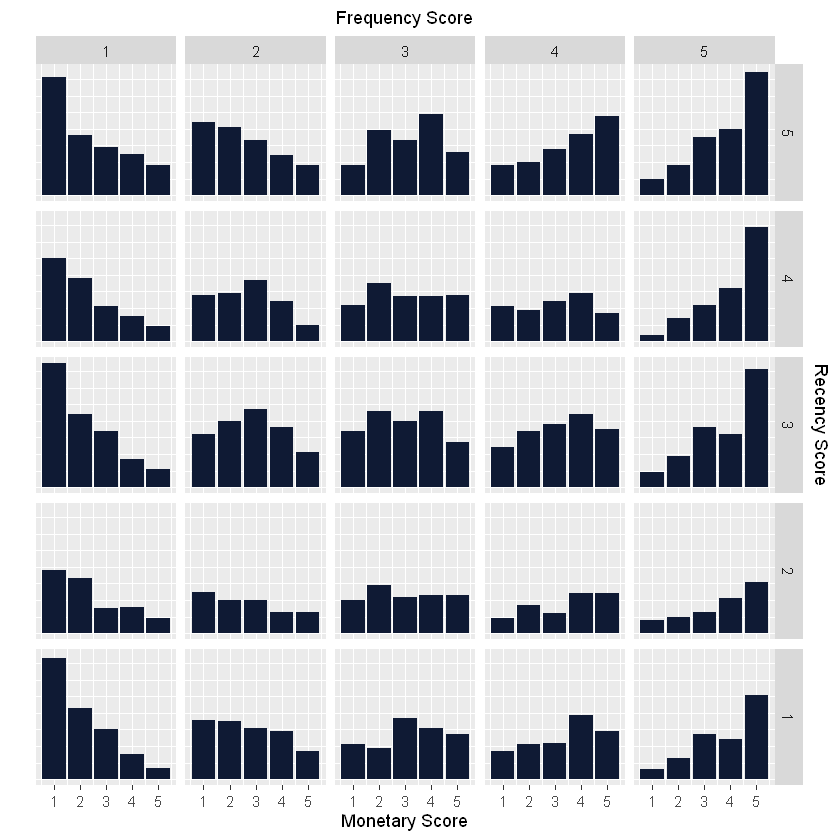

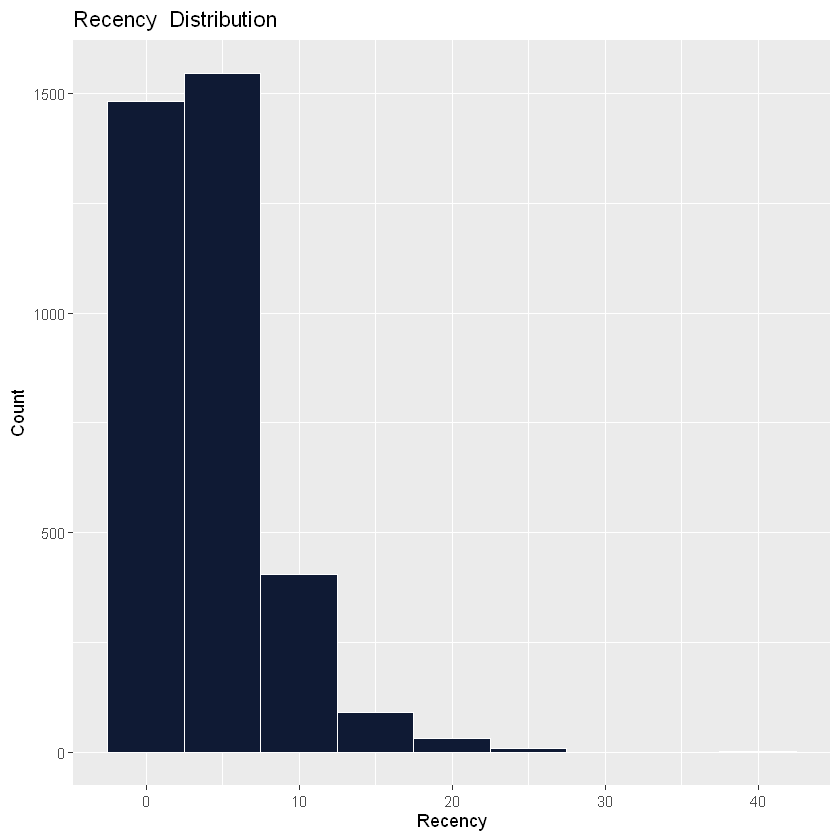

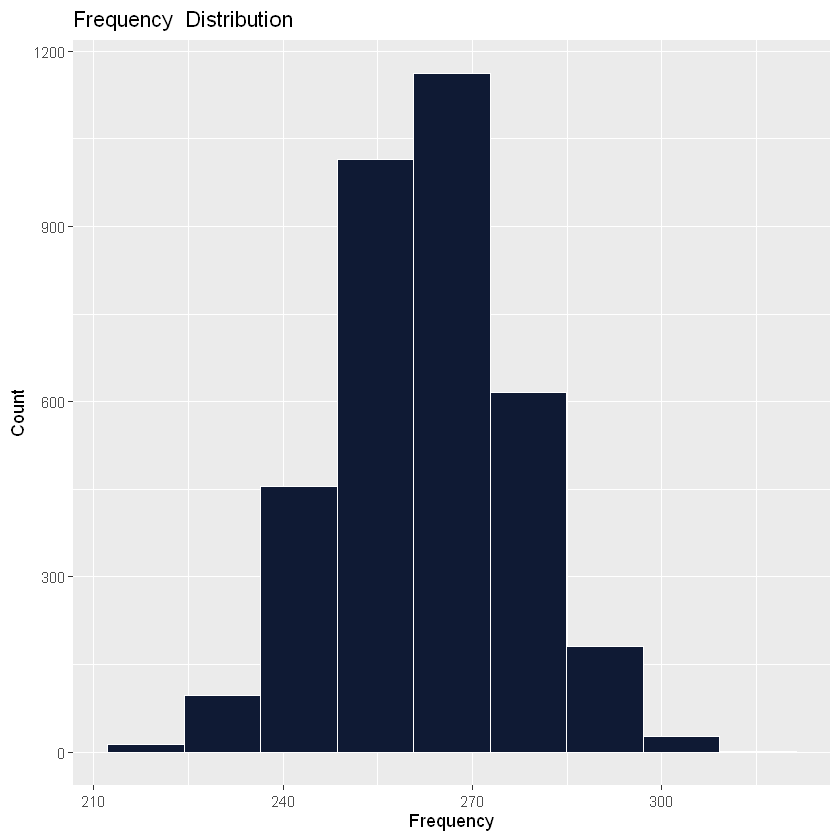

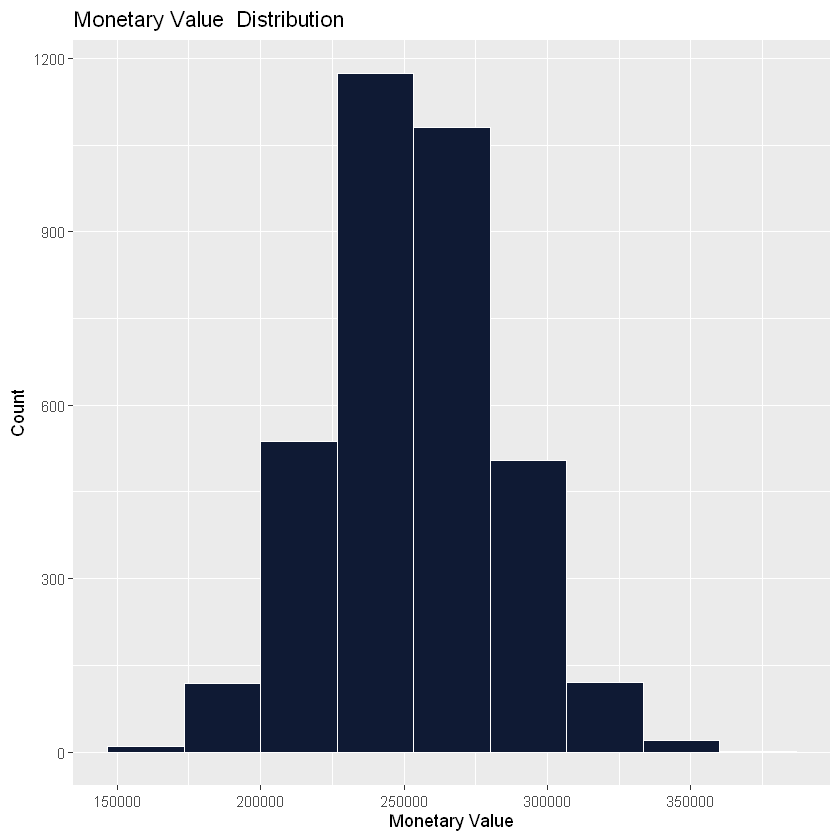

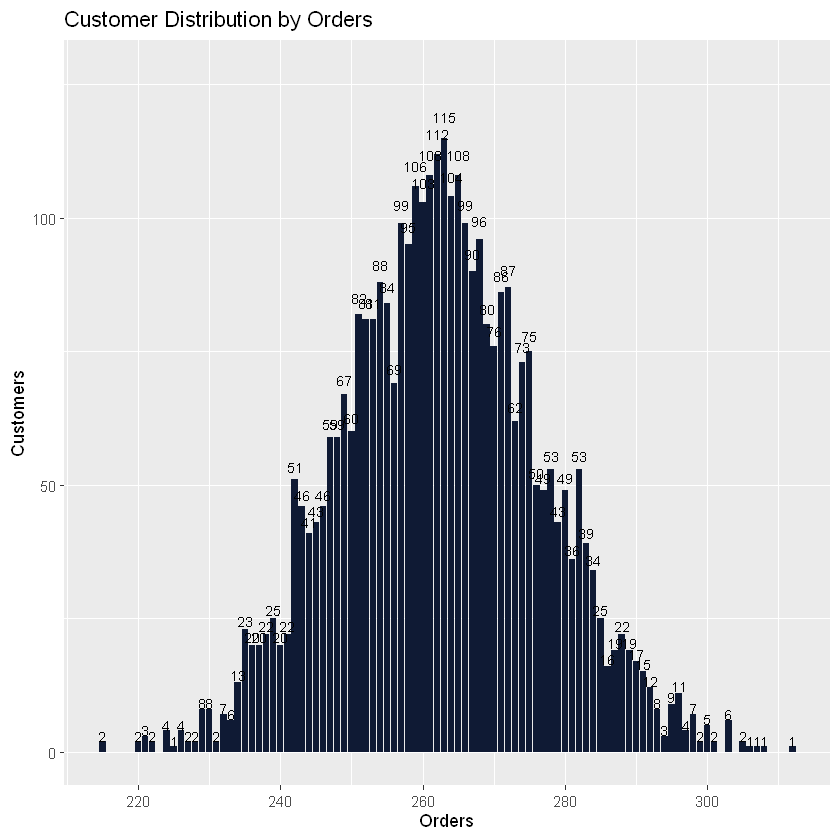

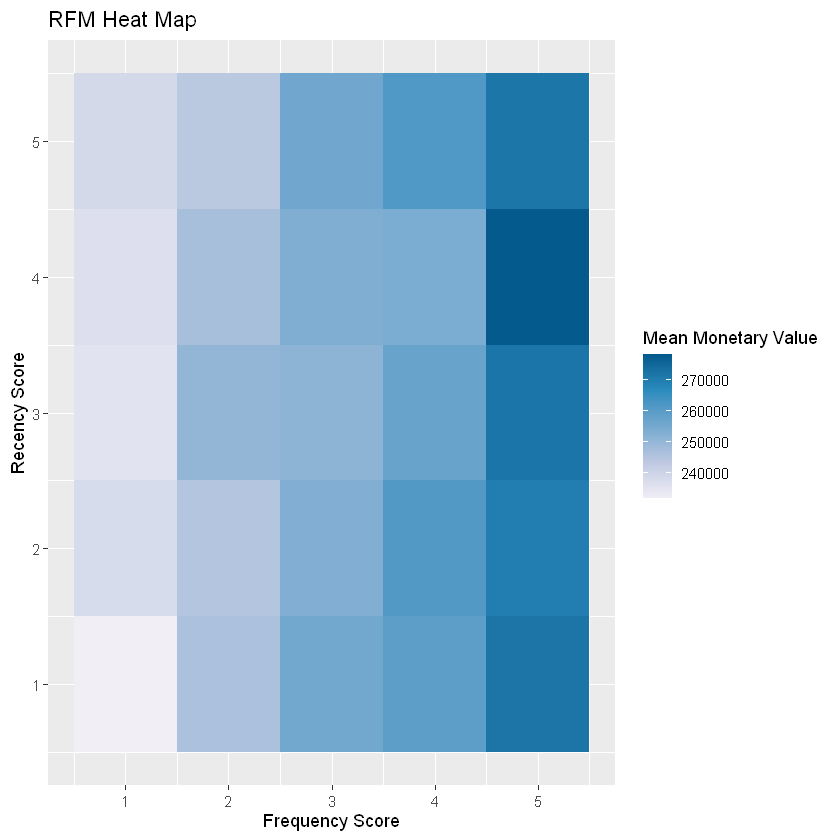

In [10]:
# B2B customers
# Visualize distribution of RFM scores (count of customers per total RFM score)
rfm_plot_bar_chart(rfm_result_b2b)
# Distribution of recency scores (how recently customers made a purchase)
rfm_plot_histogram(rfm_result_b2b, metric = "recency")
# Distribution of frequency scores (how often customers purchased)
rfm_plot_histogram(rfm_result_b2b, metric = "frequency")
# Distribution of monetary scores (how much customers spent)
rfm_plot_histogram(rfm_result_b2b, metric = "monetary")
# Frequency of RFM score combinations (e.g., RFM = 555, 444, etc.)
rfm_plot_order_dist(rfm_result_b2b)
# Heatmap of average monetary value by Recency and Frequency segments
rfm_plot_heatmap(rfm_result_b2b)

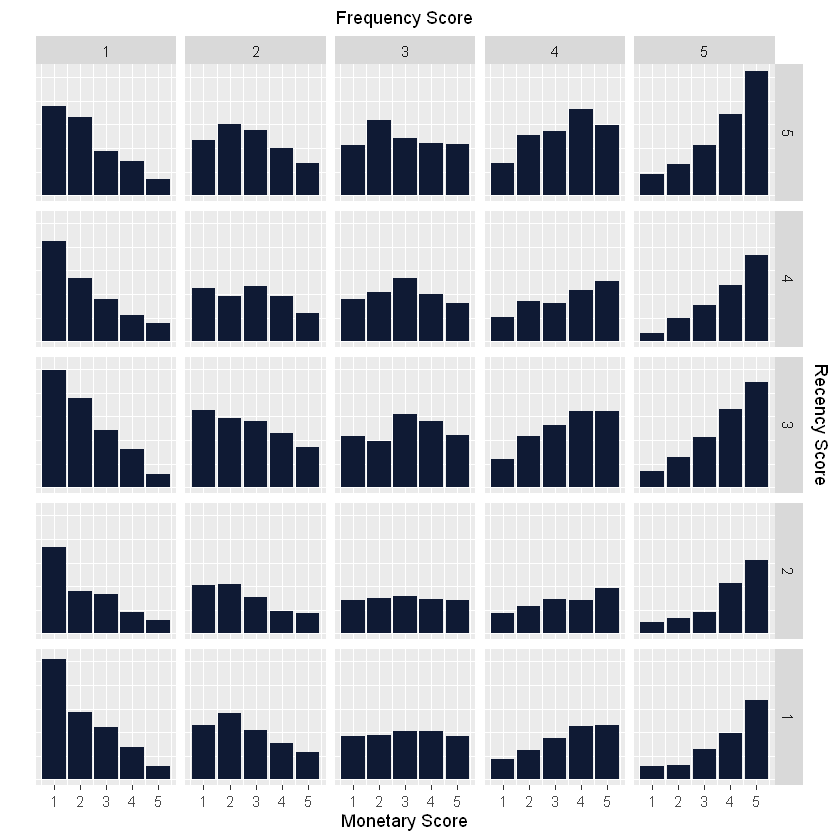

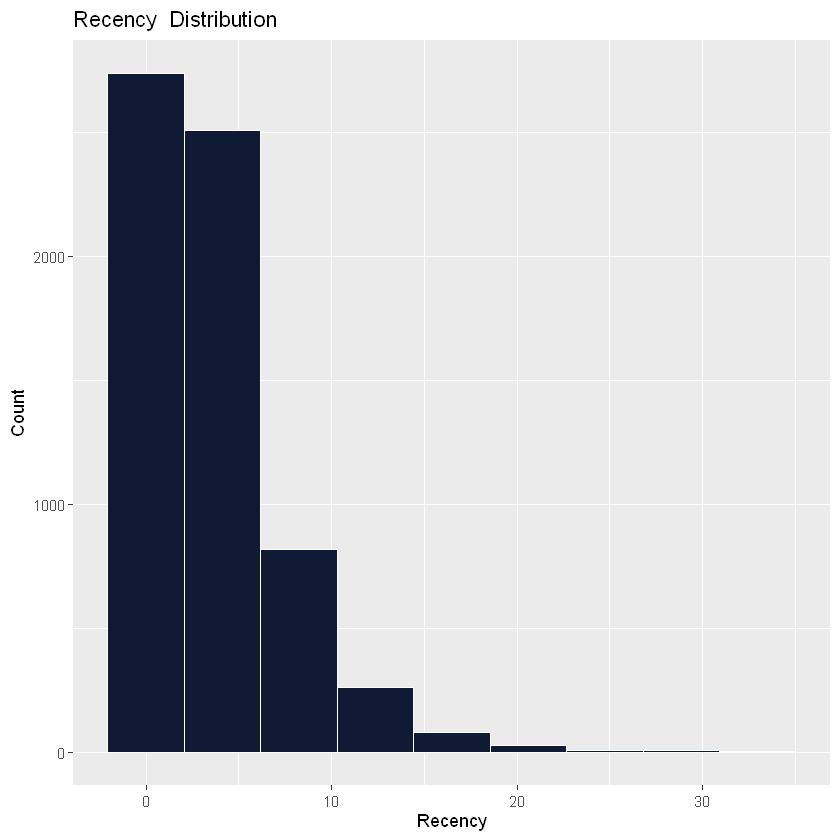

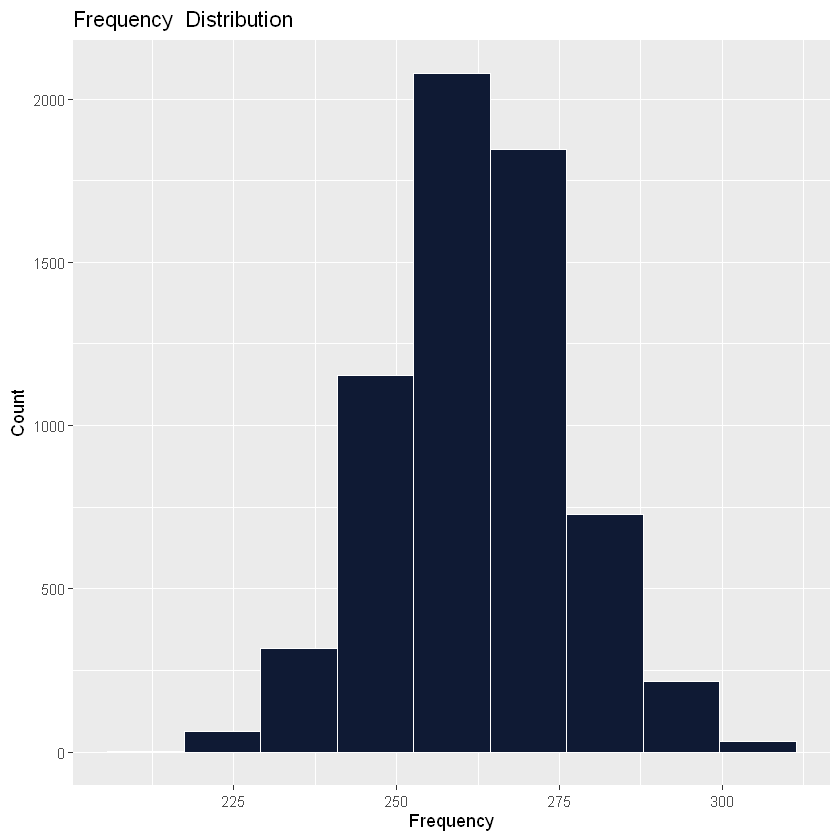

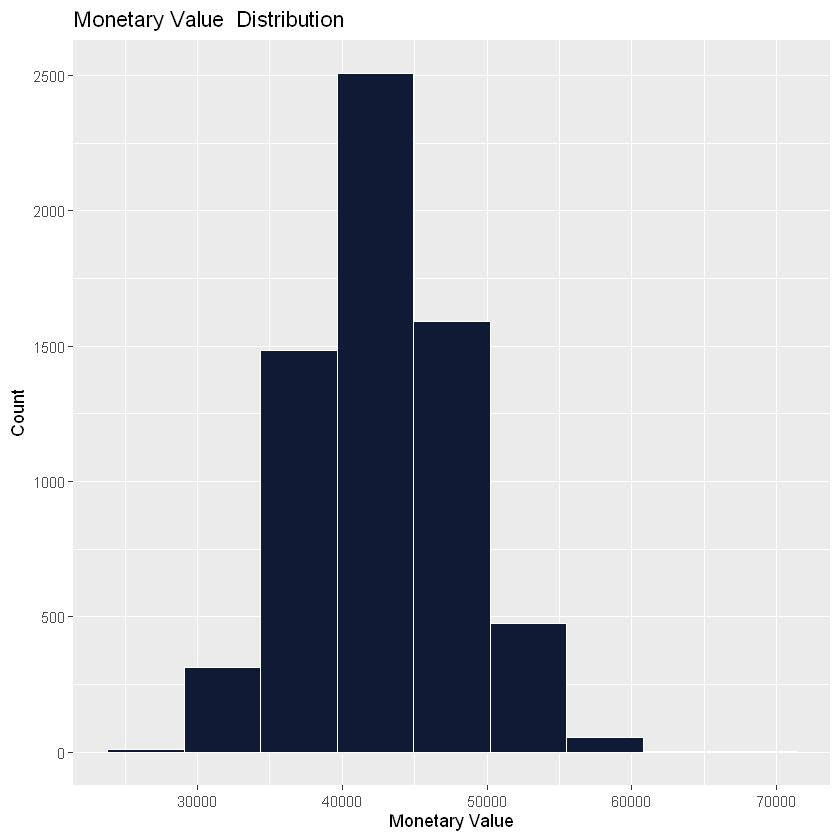

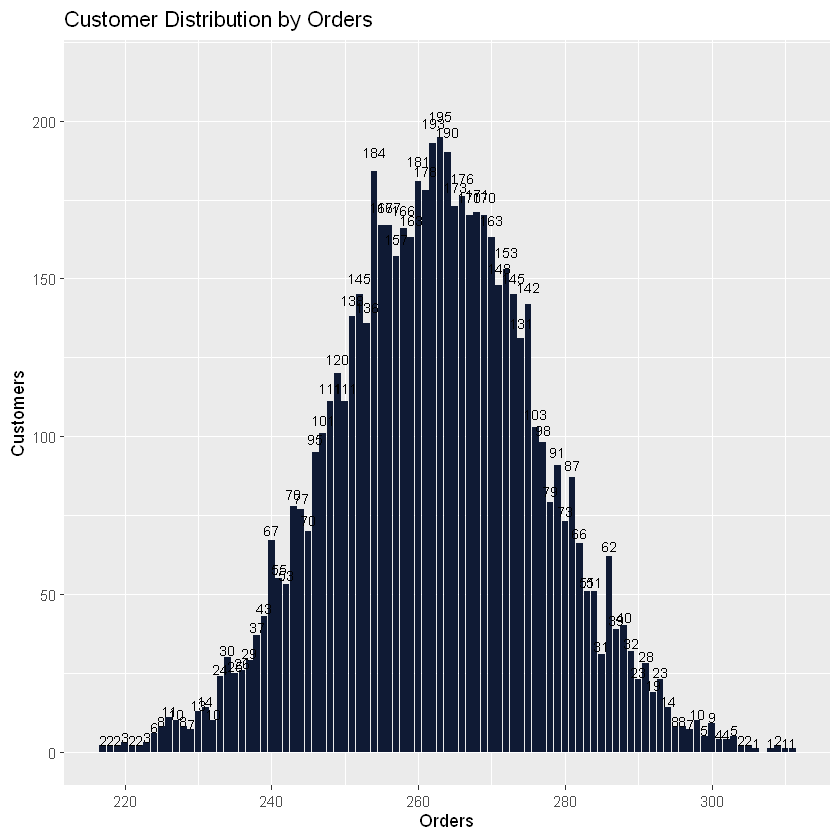

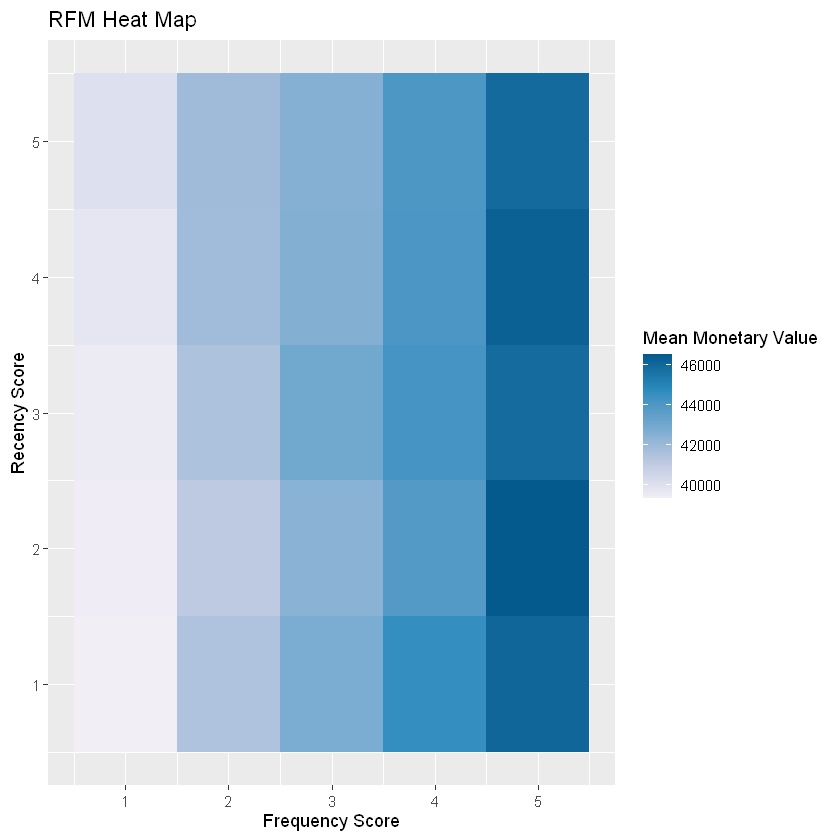

In [11]:
# B2C customers
# Same set of RFM visualizations applied to B2C segment
rfm_plot_bar_chart(rfm_result_b2c)
rfm_plot_histogram(rfm_result_b2c, metric = "recency")
rfm_plot_histogram(rfm_result_b2c, metric = "frequency")
rfm_plot_histogram(rfm_result_b2c, metric = "monetary")
rfm_plot_order_dist(rfm_result_b2c)
rfm_plot_heatmap(rfm_result_b2c)

### RFM Segmentation

In [12]:
# Manually assign RFM-based customer segments based on score combinations
# These rules are based on the RFM segmentation taught in the lecture
# B2B customers
rfm_segmented_b2b <- rfm_result_b2b$rfm %>%
  mutate(
    segment = case_when(
      recency_score %in% 4:5 & frequency_score %in% 4:5 & monetary_score %in% 4:5 ~ "Champions",
      recency_score %in% 2:5 & frequency_score %in% 3:5 & monetary_score %in% 3:5 ~ "Loyal Customers",
      recency_score %in% 3:5 & frequency_score %in% 1:3 & monetary_score %in% 1:3 ~ "Potential Loyalist",
      recency_score %in% 4:5 & frequency_score <= 1 & monetary_score <= 1 ~ "New Customers",
      recency_score %in% 3:4 & frequency_score <= 1 & monetary_score <= 1 ~ "Promising",
      recency_score %in% 2:3 & frequency_score %in% 2:3 & monetary_score %in% 2:3 ~ "Need Attention",
      recency_score %in% 2:3 & frequency_score <= 2 & monetary_score <= 2 ~ "About To Sleep",
      recency_score <= 2 & frequency_score %in% 2:5 & monetary_score %in% 2:5 ~ "At Risk",
      recency_score <= 1 & frequency_score %in% 4:5 & monetary_score %in% 4:5 ~ "Can’t Lose Them",
      recency_score %in% 1:2 & frequency_score %in% 1:2 & monetary_score %in% 1:2 ~ "Hibernating",
      recency_score <= 2 & frequency_score <= 2 & monetary_score <= 2 ~ "Lost",
      TRUE ~ "Uncategorized"
    )
  )
# B2C customers
rfm_segmented_b2c <- rfm_result_b2c$rfm %>%
  mutate(
    segment = case_when(
      recency_score %in% 4:5 & frequency_score %in% 4:5 & monetary_score %in% 4:5 ~ "Champions",
      recency_score %in% 2:5 & frequency_score %in% 3:5 & monetary_score %in% 3:5 ~ "Loyal Customers",
      recency_score %in% 3:5 & frequency_score %in% 1:3 & monetary_score %in% 1:3 ~ "Potential Loyalist",
      recency_score %in% 4:5 & frequency_score <= 1 & monetary_score <= 1 ~ "New Customers",
      recency_score %in% 3:4 & frequency_score <= 1 & monetary_score <= 1 ~ "Promising",
      recency_score %in% 2:3 & frequency_score %in% 2:3 & monetary_score %in% 2:3 ~ "Need Attention",
      recency_score %in% 2:3 & frequency_score <= 2 & monetary_score <= 2 ~ "About To Sleep",
      recency_score <= 2 & frequency_score %in% 2:5 & monetary_score %in% 2:5 ~ "At Risk",
      recency_score <= 1 & frequency_score %in% 4:5 & monetary_score %in% 4:5 ~ "Can’t Lose Them",
      recency_score %in% 1:2 & frequency_score %in% 1:2 & monetary_score %in% 1:2 ~ "Hibernating",
      recency_score <= 2 & frequency_score <= 2 & monetary_score <= 2 ~ "Lost",
      TRUE ~ "Uncategorized"
    )
  )

In [13]:
# ------------------------------ Segment Summary ------------------------------
# Calculate total number of customers for B2B
total_customers <- nrow(rfm_segmented_b2b)
# Define all possible segments to ensure complete reporting
all_segments <- c(
  "Champions", "Loyal Customers", "Potential Loyalist", "New Customers",
  "Promising", "Need Attention", "About To Sleep", "At Risk",
  "Can’t Lose Them", "Hibernating", "Lost", "Uncategorized"
)
# Aggregate segment metrics for B2B: size, avg. spending, transactions, recency
segment_analysis_b2b <- rfm_segmented_b2b %>%
  group_by(segment) %>%
  summarise(
    no_customers = n(),
    avg_spending = round(mean(amount, na.rm = TRUE), 2),
    avg_transactions = round(mean(transaction_count, na.rm = TRUE), 2),
    avg_recency_days = round(mean(recency_days, na.rm = TRUE), 1),
    .groups = "drop"
  ) %>%
  mutate(
    total_customers = total_customers,
    percentage = round(100 * no_customers / total_customers, 1)
  ) %>%
  right_join(tibble(segment = all_segments), by = "segment") %>%
  replace_na(list(
    no_customers = 0,
    avg_spending = 0,
    avg_transactions = 0,
    avg_recency_days = 0,
    percentage = 0,
    total_customers = total_customers
  )) %>%
  arrange(factor(segment, levels = all_segments))

In [14]:
# Repeat the same steps for B2C
total_customers <- nrow(rfm_segmented_b2c)

segment_analysis_b2c <- rfm_segmented_b2c %>%
  group_by(segment) %>%
  summarise(
    no_customers = n(),
    avg_spending = round(mean(amount, na.rm = TRUE), 2),
    avg_transactions = round(mean(transaction_count, na.rm = TRUE), 2),
    avg_recency_days = round(mean(recency_days, na.rm = TRUE), 1),
    .groups = "drop"
  ) %>%
  mutate(
    total_customers = total_customers,
    percentage = round(100 * no_customers / total_customers, 1)
  ) %>%
  right_join(tibble(segment = all_segments), by = "segment") %>%
  replace_na(list(
    no_customers = 0,
    avg_spending = 0,
    avg_transactions = 0,
    avg_recency_days = 0,
    percentage = 0,
    total_customers = total_customers
  )) %>%
  arrange(factor(segment, levels = all_segments))

In [15]:
# ------------------------------ Output Tables ------------------------------
# Summary tables per segment for reporting
kable(segment_analysis_b2b, caption = "RFM Segment Summary – B2B", digits = 2)
kable(segment_analysis_b2c, caption = "RFM Segment Summary – B2C", digits = 2)

# Display a few examples of customers that could not be assigned to a segment
rfm_segmented_b2c %>%
  filter(segment == "Uncategorized") %>%
  select(customer_id, recency_score, frequency_score, monetary_score, amount, transaction_count, recency_days) %>%
  head(10)




Table: RFM Segment Summary – B2B

|segment            | no_customers| avg_spending| avg_transactions| avg_recency_days| total_customers| percentage|
|:------------------|------------:|------------:|----------------:|----------------:|---------------:|----------:|
|Champions          |          346|     286637.7|           278.65|              1.4|            3563|        9.7|
|Loyal Customers    |          861|     270568.3|           270.97|              3.2|            3563|       24.2|
|Potential Loyalist |          923|     230295.2|           252.08|              2.2|            3563|       25.9|
|New Customers      |            0|          0.0|             0.00|              0.0|            3563|        0.0|
|Promising          |            0|          0.0|             0.00|              0.0|            3563|        0.0|
|Need Attention     |           69|     241827.5|           258.45|              5.4|            3563|        1.9|
|About To Sleep     |           96|     2183



Table: RFM Segment Summary – B2C

|segment            | no_customers| avg_spending| avg_transactions| avg_recency_days| total_customers| percentage|
|:------------------|------------:|------------:|----------------:|----------------:|---------------:|----------:|
|Champions          |          652|     48376.31|           277.98|              1.4|            6437|       10.1|
|Loyal Customers    |         1589|     45834.36|           271.18|              3.3|            6437|       24.7|
|Potential Loyalist |         1646|     38665.34|           251.68|              2.2|            6437|       25.6|
|New Customers      |            0|         0.00|             0.00|              0.0|            6437|        0.0|
|Promising          |            0|         0.00|             0.00|              0.0|            6437|        0.0|
|Need Attention     |          127|     40608.60|           258.06|              5.4|            6437|        2.0|
|About To Sleep     |          187|     3634

customer_id,recency_score,frequency_score,monetary_score,amount,transaction_count,recency_days
<chr>,<int>,<int>,<int>,<dbl>,<int>,<dbl>
CUS1001,5,4,1,35749.85,268,1
CUS1003,5,2,4,45890.74,254,1
CUS1015,4,4,2,41273.83,268,2
CUS1039,5,5,1,34475.56,275,1
CUS1040,4,4,1,32852.74,273,2
CUS1041,4,4,2,40552.85,270,2
CUS1050,4,5,1,35897.40,283,2
CUS1056,2,4,1,37257.30,268,5
CUS1087,1,3,1,36951.99,261,7


### Custom RFM Segmentation

In [16]:
# Define extended set of RFM segments (custom categories)
# This includes standard segments and new ones like:
# "Dormant High Value", "Occasional Shoppers", etc.
all_segments <- c(
  "Champions", "Loyal Customers", "Potential Loyalist",
  "New Customers", "Need Attention", "Promising",
  "About To Sleep", "At Risk", "Can’t Lose Them",
  "Hibernating", "Lost", "Dormant High Value",
  "Occasional Shoppers"
)

# B2C Segmentation

# Assign each B2C customer to a segment based on detailed RFM scoring logic
rfm_segmented_b2c <- rfm_result_b2c$rfm %>%
  mutate(
    segment = case_when(
      recency_score >= 5 & frequency_score >= 5 & monetary_score >= 5 ~ "Champions",
      recency_score >= 4 & frequency_score >= 4 & monetary_score >= 4 ~ "Loyal Customers",
      recency_score >= 4 & frequency_score >= 3 & monetary_score >= 3 ~ "Potential Loyalist",
      recency_score >= 4 & frequency_score >= 2 & monetary_score >= 2 ~ "New Customers",
      recency_score >= 3 & frequency_score == 2 ~ "Occasional Shoppers",
      recency_score >= 3 & frequency_score >= 3 & monetary_score >= 3 ~ "Need Attention",
      recency_score >= 3 & frequency_score == 1 ~ "Promising",
      recency_score >= 2 & frequency_score >= 3 ~ "At Risk",
      recency_score >= 2 & frequency_score == 2 ~ "About To Sleep",
      recency_score >= 1 & frequency_score >= 3 ~ "Can’t Lose Them",
      recency_score >= 1 & frequency_score <= 2 & monetary_score <= 3 ~ "Hibernating",
      recency_score >= 3 & monetary_score >= 3 ~ "Active High Value",
      recency_score >= 3 & monetary_score >= 2 ~ "Active Medium Value",
      recency_score < 3 & monetary_score >= 2 ~ "Dormant High Value",
      recency_score <= 1 & frequency_score <= 1 & monetary_score <= 1 ~ "Lost",
      TRUE ~ "Uncategorized"
    )
  )

# Calculate total number of B2C customers (needed for percentage computation)
total_customers <- nrow(rfm_segmented_b2c)

# Aggregate statistics per segment for B2C
segment_analysis_b2c <- rfm_segmented_b2c %>%
  group_by(segment) %>%
  summarise(
    no_customers = n(),
    avg_spending = round(mean(amount, na.rm = TRUE), 2),
    avg_transactions = round(mean(transaction_count, na.rm = TRUE), 2),
    avg_recency_days = round(mean(recency_days, na.rm = TRUE), 1),
    .groups = "drop"
  ) %>%
  mutate(
    total_customers = total_customers,
    percentage = round(100 * no_customers / total_customers, 1)
  ) %>%
  right_join(tibble(segment = all_segments), by = "segment") %>%
  replace_na(list(
    no_customers = 0,
    avg_spending = 0,
    avg_transactions = 0,
    avg_recency_days = 0,
    percentage = 0,
    total_customers = total_customers
  )) %>%
  arrange(factor(segment, levels = all_segments))

In [17]:
# B2B Segmentation
# Apply same custom logic to B2B customers
rfm_segmented_b2b <- rfm_result_b2b$rfm %>%
  mutate(
    segment = case_when(
      recency_score >= 5 & frequency_score >= 5 & monetary_score >= 5 ~ "Champions",
      recency_score >= 4 & frequency_score >= 4 & monetary_score >= 4 ~ "Loyal Customers",
      recency_score >= 4 & frequency_score >= 3 & monetary_score >= 3 ~ "Potential Loyalist",
      recency_score >= 4 & frequency_score >= 2 & monetary_score >= 2 ~ "New Customers",
      recency_score >= 3 & frequency_score == 2 ~ "Occasional Shoppers",
      recency_score >= 3 & frequency_score >= 3 & monetary_score >= 3 ~ "Need Attention",
      recency_score >= 3 & frequency_score == 1 ~ "Promising",
      recency_score >= 2 & frequency_score >= 3 ~ "At Risk",
      recency_score >= 2 & frequency_score == 2 ~ "About To Sleep",
      recency_score >= 1 & frequency_score >= 3 ~ "Can’t Lose Them",
      recency_score >= 1 & frequency_score <= 2 & monetary_score <= 3 ~ "Hibernating",
      recency_score >= 3 & monetary_score >= 3 ~ "Active High Value",
      recency_score >= 3 & monetary_score >= 2 ~ "Active Medium Value",
      recency_score < 3 & monetary_score >= 2 ~ "Dormant High Value",
      recency_score <= 1 & frequency_score <= 1 & monetary_score <= 1 ~ "Lost",
      TRUE ~ "Uncategorized"
    )
  )

# Calculate total number of B2B customers
total_customers <- nrow(rfm_segmented_b2b)

# Aggregate statistics per segment for B2B
segment_analysis_b2b <- rfm_segmented_b2b %>%
  group_by(segment) %>%
  summarise(
    no_customers = n(),
    avg_spending = round(mean(amount, na.rm = TRUE), 2),
    avg_transactions = round(mean(transaction_count, na.rm = TRUE), 2),
    avg_recency_days = round(mean(recency_days, na.rm = TRUE), 1),
    .groups = "drop"
  ) %>%
  mutate(
    total_customers = total_customers,
    percentage = round(100 * no_customers / total_customers, 1)
  ) %>%
  right_join(tibble(segment = all_segments), by = "segment") %>%
  replace_na(list(
    no_customers = 0,
    avg_spending = 0,
    avg_transactions = 0,
    avg_recency_days = 0,
    percentage = 0,
    total_customers = total_customers
  )) %>%
  arrange(factor(segment, levels = all_segments))

In [18]:
# --------------------------- Display Tables ------------------------------------
# Output final segment analysis tables
kable(segment_analysis_b2b, caption = "RFM Analysis – B2B")
kable(segment_analysis_b2c, caption = "RFM Analysis – B2C")



Table: RFM Analysis – B2B

|segment             | no_customers| avg_spending| avg_transactions| avg_recency_days| total_customers| percentage|
|:-------------------|------------:|------------:|----------------:|----------------:|---------------:|----------:|
|Champions           |           74|     298748.1|           284.18|              1.0|            3563|        2.1|
|Loyal Customers     |          272|     283342.9|           277.15|              1.5|            3563|        7.6|
|Potential Loyalist  |          299|     263104.2|           267.87|              1.4|            3563|        8.4|
|New Customers       |          361|     248663.4|           261.05|              1.5|            3563|       10.1|
|Need Attention      |          369|     273916.7|           272.87|              3.4|            3563|       10.4|
|Promising           |          493|     236679.6|           244.05|              2.1|            3563|       13.8|
|About To Sleep      |           91|     24



Table: RFM Analysis – B2C

|segment             | no_customers| avg_spending| avg_transactions| avg_recency_days| total_customers| percentage|
|:-------------------|------------:|------------:|----------------:|----------------:|---------------:|----------:|
|Champions           |          132|     50804.62|           283.86|              1.0|            6437|        2.1|
|Loyal Customers     |          520|     47759.89|           276.48|              1.5|            6437|        8.1|
|Potential Loyalist  |          527|     44447.95|           267.71|              1.4|            6437|        8.2|
|New Customers       |          709|     42069.03|           261.40|              1.4|            6437|       11.0|
|Need Attention      |          679|     46423.69|           272.65|              3.4|            6437|       10.5|
|Promising           |          877|     39725.04|           243.83|              2.2|            6437|       13.6|
|About To Sleep      |          186|     41

### Plots

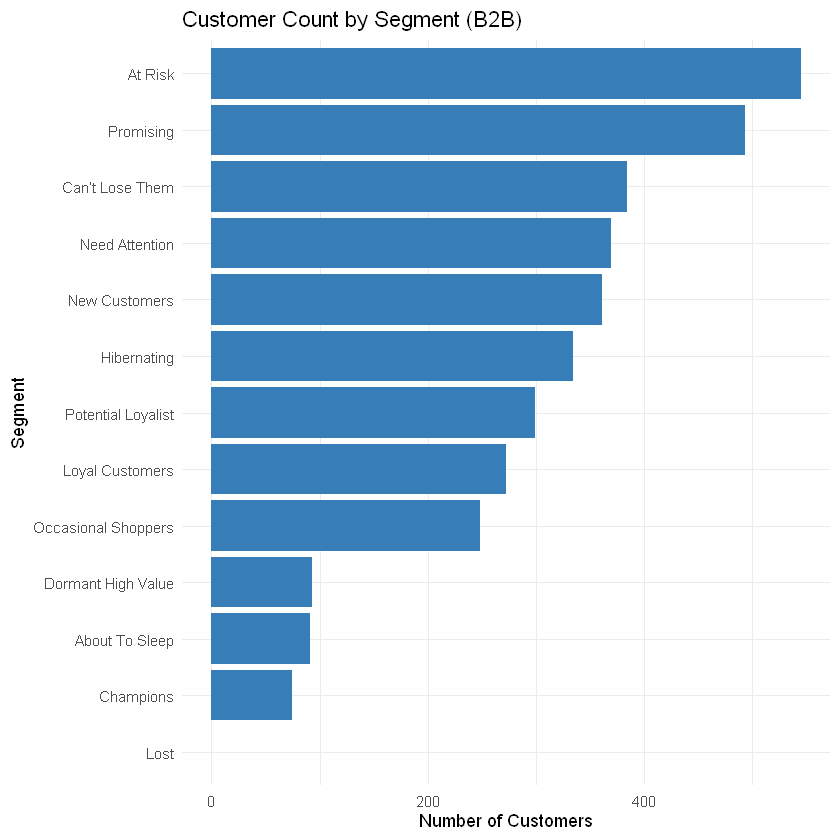

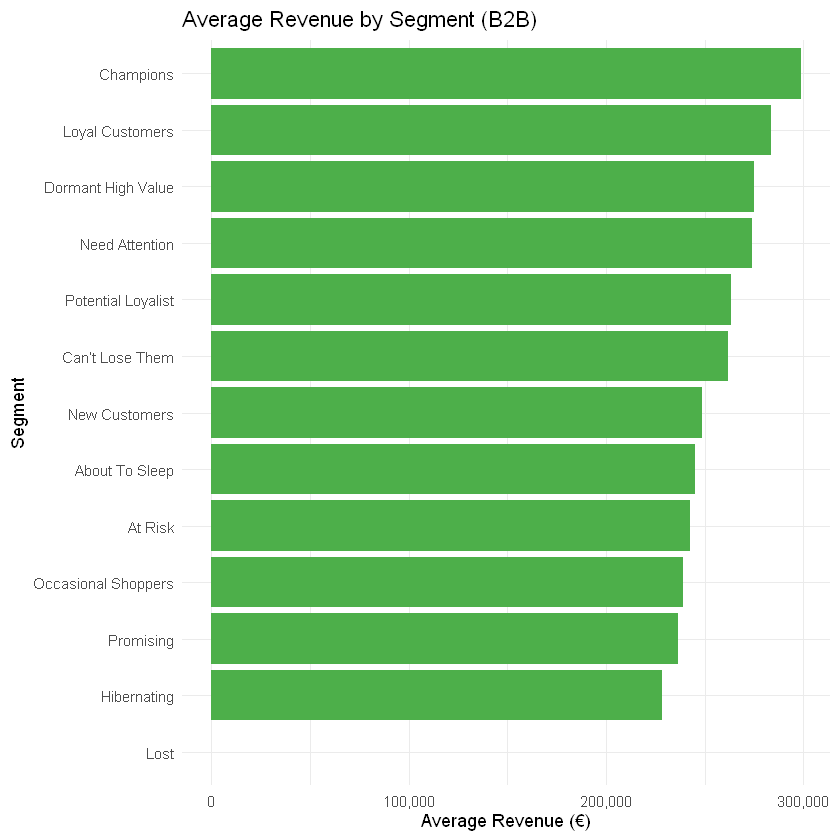

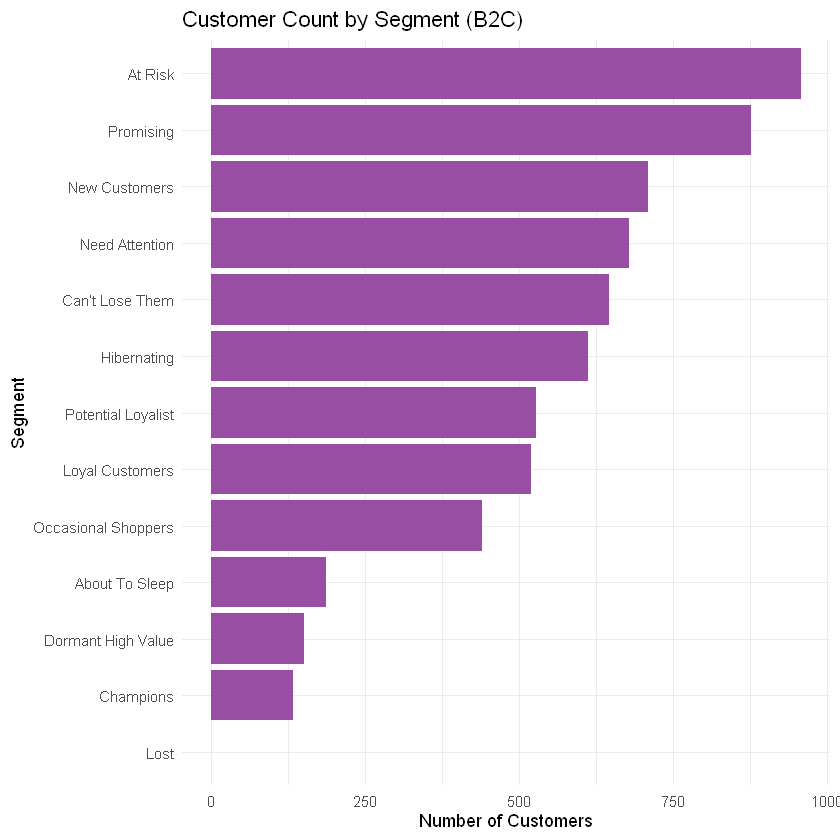

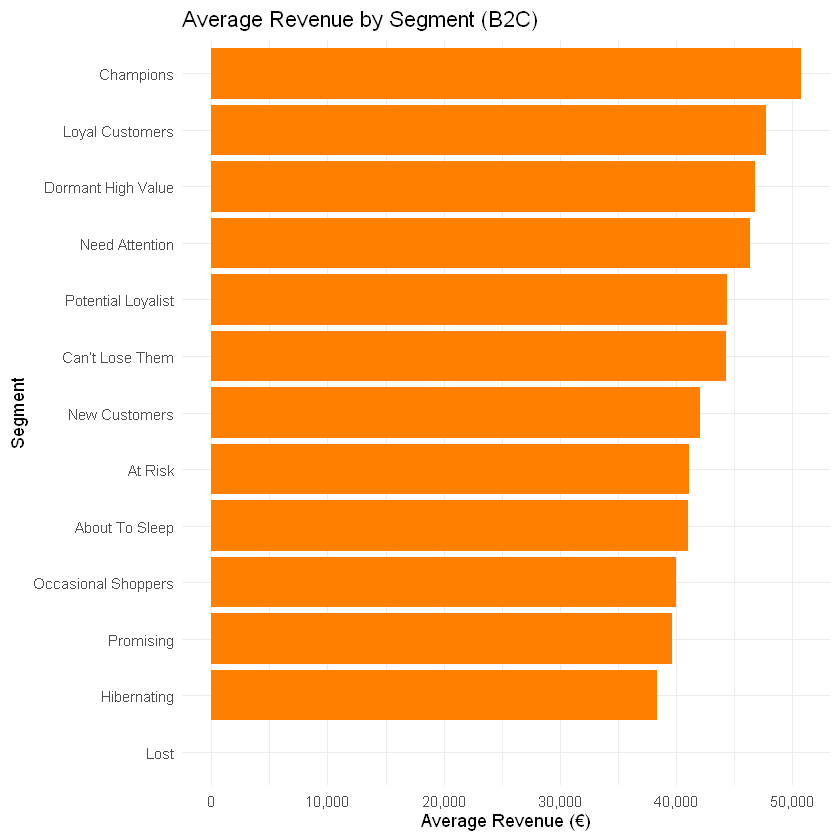

In [19]:
# ---- B2B: Kundenanzahl pro Segment ----
ggplot(segment_analysis_b2b, aes(x = reorder(segment, no_customers), y = no_customers)) +
  geom_bar(stat = "identity", fill = "#377eb8") +
  coord_flip() +
  labs(
    title = "Customer Count by Segment (B2B)",
    x = "Segment",
    y = "Number of Customers"
  ) +
  theme_minimal()

# ---- B2B: Durchschnittlicher Umsatz pro Segment ----
ggplot(segment_analysis_b2b, aes(x = reorder(segment, avg_spending), y = avg_spending)) +
  geom_bar(stat = "identity", fill = "#4daf4a") +
  coord_flip() +
  labs(
    title = "Average Revenue by Segment (B2B)",
    x = "Segment",
    y = "Average Revenue (€)"
  ) +
  scale_y_continuous(labels = comma) +
  theme_minimal()

# ---- B2C: Kundenanzahl pro Segment ----
ggplot(segment_analysis_b2c, aes(x = reorder(segment, no_customers), y = no_customers)) +
  geom_bar(stat = "identity", fill = "#984ea3") +
  coord_flip() +
  labs(
    title = "Customer Count by Segment (B2C)",
    x = "Segment",
    y = "Number of Customers"
  ) +
  theme_minimal()

# ---- B2C: Durchschnittlicher Umsatz pro Segment ----
ggplot(segment_analysis_b2c, aes(x = reorder(segment, avg_spending), y = avg_spending)) +
  geom_bar(stat = "identity", fill = "#ff7f00") +
  coord_flip() +
  labs(
    title = "Average Revenue by Segment (B2C)",
    x = "Segment",
    y = "Average Revenue (€)"
  ) +
  scale_y_continuous(labels = comma) +
  theme_minimal()

# Multiple Linear Regression

In [20]:

# -------------------- Top 10 Products by Revenue (B2B and B2C) --------------------
# B2B: Calculate total revenue per product and return the top 10
top_revenue_b2b <- line_wise_b2b %>%
  group_by(product) %>%
  summarise(
    total_revenue = sum(total_price, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(desc(total_revenue)) %>%
  slice_head(n = 10)
# B2C: Same logic applied to B2C customers
top_revenue_b2c <- line_wise_b2c %>%
  group_by(product) %>%
  summarise(
    total_revenue = sum(total_price, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(desc(total_revenue)) %>%
  slice_head(n = 10)
kable(top_revenue_b2b, caption = "Top 10 Products by Revenue – B2B", digits = 2)
kable(top_revenue_b2c, caption = "Top 10 Products by Revenue – B2C", digits = 2)



Table: Top 10 Products by Revenue – B2B

|product         | total_revenue|
|:---------------|-------------:|
|Moët & Chandon  |     139543793|
|Veuve Clicquot  |     137528584|
|Johnnie Walker  |      75422676|
|Jack Daniels    |      66066217|
|Tanqueray       |      65537046|
|Havana Club     |      50321112|
|Bacardi         |      50282108|
|Riesling        |      19929136|
|Chardonnay      |      18193599|
|Sauvignon Blanc |      18080395|



Table: Top 10 Products by Revenue – B2C

|product          | total_revenue|
|:----------------|-------------:|
|Veuve Clicquot   |      65053315|
|Moët & Chandon   |      35544293|
|Jack Daniels     |      29814786|
|Johnnie Walker   |      21839125|
|Tanqueray        |      20606609|
|Bacardi          |       8185396|
|Havana Club      |       7725853|
|Cranberry Juice  |       5860585|
|Tomato Juice     |       5448523|
|Rotkäppchen Sekt |       5401697|

### MLR per Product
To identify the impact of discount, region, and month on quantity sold

In [21]:
# Prepare B2B data: define region, discount, and month as predictors
b2b_prepped <- line_wise_b2b %>%
  mutate(
    region   = as.factor(region),
    product  = as.factor(product),
    discount = as.numeric(discount),
    month    = factor(format(order_date, "%m")) # adds seasonal effect
  ) %>%
  select(product, quantity, discount, region, month)

# Define a list of top-selling products for B2B
top_products_b2b <- c(
  "Moët & Chandon", "Veuve Clicquot", "Johnnie Walker", "Jack Daniels",
  "Tanqueray", "Havana Club", "Bacardi", "Riesling", "Chardonnay",
  "Sauvignon Blanc"
)

# Store regression summaries for each product
model_summaries_b2b <- list()

for (prod in top_products_b2b) {
  df_product <- b2b_prepped %>% filter(product == prod)

  if (nrow(df_product) >= 50) { # Ensure sufficient sample size
    model_b2b <- lm(quantity ~ discount + region + month, data = df_product)
    model_summaries_b2b[[prod]] <- summary(model_b2b)
  }
}

# Output regression results per product
for (prod in names(model_summaries_b2b)) {
  cat("\n==========================================\n")
  cat(" B2B Regression Summary for:", prod, "\n")
  cat("==========================================\n")
  print(model_summaries_b2b[[prod]])
}


 B2B Regression Summary for: Moët & Chandon 

Call:
lm(formula = quantity ~ discount + region + month, data = df_product)

Residuals:
    Min      1Q  Median      3Q     Max 
-79.162 -18.488   0.308  18.681  65.819 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   14.093005   0.722052  19.518   <2e-16 ***
discount                     428.153693   3.650070 117.300   <2e-16 ***
regionBayern                   0.236709   0.714150   0.331   0.7403    
regionBerlin                   1.595406   0.701322   2.275   0.0229 *  
regionBrandenburg              0.487704   0.706469   0.690   0.4900    
regionBremen                  -0.179946   0.736223  -0.244   0.8069    
regionHamburg                  0.783017   0.689596   1.135   0.2562    
regionHessen                  -1.083263   0.686308  -1.578   0.1145    
regionMecklenburg-Vorpommern   1.304782   0.698827   1.867   0.0619 .  
regionNiedersachsen           -0.167752   0.7187

In [22]:
b2c_prepped <- line_wise_b2c %>%
  mutate(
    region   = as.factor(region),
    product  = as.factor(product),
    month    = factor(format(order_date, "%m"))
  ) %>%
  select(product, quantity, region, month)

# Define a list of top-selling products for B2C
top_products_b2c <- c(
  "Veuve Clicquot", "Moët & Chandon", "Jack Daniels", "Johnnie Walker",
  "Tanqueray", "Bacardi", "Havana Club", "Cranberry Juice", "Tomato Juice",
  "Rotkäppchen Sekt"
)

# Store regression summaries for each product
model_summaries_b2c <- list()

for (prod in top_products_b2c) {
  df_product <- b2c_prepped %>% filter(product == prod)

  if (nrow(df_product) >= 50) {
    model_b2c <- lm(quantity ~ region + month, data = df_product)
    model_summaries_b2c[[prod]] <- summary(model_b2c)
  }
}

# Output regression results per product
for (prod in names(model_summaries_b2c)) {
  cat("\n==========================================\n")
  cat("B2C Regression Summary for:", prod, "\n")
  cat("==========================================\n")
  print(model_summaries_b2c[[prod]])
}


B2C Regression Summary for: Veuve Clicquot 

Call:
lm(formula = quantity ~ region + month, data = df_product)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.2691 -3.9539 -0.0261  3.9051  7.2657 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   8.032687   0.081428  98.648   <2e-16 ***
regionBayern                  0.030239   0.088819   0.340   0.7335    
regionBerlin                 -0.096100   0.089943  -1.068   0.2853    
regionBrandenburg            -0.186910   0.090368  -2.068   0.0386 *  
regionBremen                  0.106696   0.093107   1.146   0.2518    
regionHamburg                -0.077091   0.087599  -0.880   0.3788    
regionHessen                 -0.014950   0.091097  -0.164   0.8696    
regionMecklenburg-Vorpommern -0.041695   0.090414  -0.461   0.6447    
regionNiedersachsen          -0.015802   0.087066  -0.181   0.8560    
regionNordrhein-Westfalen    -0.028012   0.088795  -0.315   0.7524    

### Model Evaluation

In [23]:
# Store evaluation metrics
model_metrics_b2b <- tibble(
  product       = character(),
  train_r2      = numeric(),
  train_adj_r2  = numeric(),
  test_r2       = numeric(),
  rmse_test     = numeric(),
  n_train       = integer(),
  n_test        = integer()
)

for (prod in top_products_b2b) {
  df_product <- b2b_prepped %>% filter(product == prod)

  if (nrow(df_product) >= 50) {
    set.seed(123) # reproducibility

    # Create training (80%) and test (20%) split
    train_index_b2b <- createDataPartition(df_product$quantity, p = 0.8, list = FALSE)
    train_data_b2b <- df_product[train_index_b2b, ]
    test_data_b2b <- df_product[-train_index_b2b, ]

    # Fit model on training set
    model_b2b <- lm(quantity ~ discount + region + month, data = train_data_b2b)

    # Predict on test set
    predictions_b2b <- predict(model_b2b, newdata = test_data_b2b)

    # Calculate evaluation metrics
    rmse_val_b2b <- rmse(actual = test_data_b2b$quantity, predicted = predictions_b2b)
    r2_val_b2b <- summary(model_b2b)$r.squared # training R²
    adj_r2_b2b <- summary(model_b2b)$adj.r.squared

    # Compute R² on test set
    ss_total_b2b <- sum((test_data_b2b$quantity - mean(test_data_b2b$quantity))^2)
    ss_res_b2b <- sum((test_data_b2b$quantity - predictions_b2b)^2)
    test_r2_b2b <- 1 - (ss_res_b2b / ss_total_b2b)

    # Store metrics
    model_metrics_b2b <- model_metrics_b2b %>%
      add_row(
        product       = prod,
        train_r2      = round(r2_val_b2b, 3),
        train_adj_r2  = round(adj_r2_b2b, 3),
        test_r2       = round(test_r2_b2b, 3),
        rmse_test     = round(rmse_val_b2b, 3),
        n_train       = nrow(train_data_b2b),
        n_test        = nrow(test_data_b2b)
      )
  }
}

# Display evaluation results
kable(model_metrics_b2b, caption = "Model Performance on Test Set – B2B")



Table: Model Performance on Test Set – B2B

|product         | train_r2| train_adj_r2| test_r2| rmse_test| n_train| n_test|
|:---------------|--------:|------------:|-------:|---------:|-------:|------:|
|Moët & Chandon  |    0.252|        0.252|   0.255|    24.948|   32619|   8152|
|Veuve Clicquot  |    0.257|        0.256|   0.226|    25.375|   32578|   8143|
|Johnnie Walker  |    0.268|        0.267|   0.263|    24.783|   32502|   8124|
|Jack Daniels    |    0.257|        0.256|   0.246|    25.145|   32979|   8242|
|Tanqueray       |    0.255|        0.254|   0.261|    24.931|   32689|   8171|
|Havana Club     |    0.270|        0.269|   0.252|    24.916|   32799|   8198|
|Bacardi         |    0.261|        0.261|   0.249|    25.028|   32740|   8183|
|Riesling        |    0.253|        0.252|   0.251|    24.987|   35556|   8888|
|Chardonnay      |    0.251|        0.250|   0.238|    25.166|   32879|   8218|
|Sauvignon Blanc |    0.254|        0.254|   0.260|    25.065|   32865|   

In [24]:
#------------------- Model evaluation -------------------
# Store evaluation metrics
model_metrics_b2c <- tibble(
  product       = character(),
  train_r2      = numeric(),
  train_adj_r2  = numeric(),
  test_r2       = numeric(),
  rmse_test     = numeric(),
  n_train       = integer(),
  n_test        = integer()
)

for (prod in top_products_b2c) {
  df_product <- b2c_prepped %>% filter(product == prod)

  if (nrow(df_product) >= 50) {
    set.seed(123) # reproducibility

    # Create training (80%) and test (20%) split
    train_index <- createDataPartition(df_product$quantity, p = 0.8, list = FALSE)
    train_data <- df_product[train_index, ]
    test_data <- df_product[-train_index, ]

    # Fit model on training set
    model <- lm(quantity ~ region + month, data = train_data)

    # Predict on test set
    predictions <- predict(model, newdata = test_data)

    # Calculate evaluation metrics
    rmse_val <- rmse(actual = test_data$quantity, predicted = predictions)
    r2_val <- summary(model)$r.squared # training R²
    adj_r2 <- summary(model)$adj.r.squared

    # Compute R² on test set
    ss_total <- sum((test_data$quantity - mean(test_data$quantity))^2)
    ss_res <- sum((test_data$quantity - predictions)^2)
    test_r2 <- 1 - (ss_res / ss_total)

    # Store metrics
    model_metrics_b2c <- model_metrics_b2c %>%
      add_row(
        product       = prod,
        train_r2      = round(r2_val, 3),
        train_adj_r2  = round(adj_r2, 3),
        test_r2       = round(test_r2, 3),
        rmse_test     = round(rmse_val, 3),
        n_train       = nrow(train_data),
        n_test        = nrow(test_data)
      )
  }
}

# Display evaluation results
kable(model_metrics_b2c, caption = "Model Performance on Test Set – B2B")



Table: Model Performance on Test Set – B2B

|product          | train_r2| train_adj_r2| test_r2| rmse_test| n_train| n_test|
|:----------------|--------:|------------:|-------:|---------:|-------:|------:|
|Veuve Clicquot   |    0.001|            0|  -0.001|     4.323|   59316|  14827|
|Moët & Chandon   |    0.000|            0|   0.000|     4.315|   59311|  14825|
|Jack Daniels     |    0.000|            0|   0.000|     4.315|   59300|  14822|
|Johnnie Walker   |    0.001|            0|  -0.001|     4.318|   59569|  14890|
|Tanqueray        |    0.000|            0|   0.000|     4.289|   59465|  14864|
|Bacardi          |    0.001|            0|  -0.001|     4.320|   59238|  14807|
|Havana Club      |    0.000|            0|   0.000|     4.325|   59550|  14885|
|Cranberry Juice  |    0.000|            0|   0.000|     4.328|  164529|  41130|
|Tomato Juice     |    0.000|            0|   0.000|     4.324|  163863|  40963|
|Rotkäppchen Sekt |    0.000|            0|   0.000|     4.331|

### Weekday vs Weekend analysis

In [ ]:
#------------------- Seeing if theres a difference in weekdays vs weekends -------------------
# Only one product is selected for this analysis
df_jack_weekend <- line_wise_b2c %>%
  filter(product == "Jack Daniels") %>%
  mutate(
    region      = as.factor(region),
    unit_price  = as.numeric(unit_price),
    month       = factor(month(order_date)),
    is_weekend  = ifelse(wday(order_date) %in% c(1, 7), 1, 0) # Sunday (1) und Saturday (7)
  ) %>%
  select(quantity, discount, unit_price, region, month, is_weekend) %>%
  na.omit()

# Split & Modell
set.seed(123)
idx <- createDataPartition(df_jack_weekend$quantity, p = 0.8, list = FALSE)
train <- df_jack_weekend[idx, ]
test <- df_jack_weekend[-idx, ]

model_weekend <- lm(quantity ~ unit_price + region + month + is_weekend, data = train)
summary(model_weekend)

# Evaluation
pred <- predict(model_weekend, newdata = test)
rmse <- sqrt(mean((test$quantity - pred)^2))
r2 <- 1 - sum((test$quantity - pred)^2) / sum((test$quantity - mean(test$quantity))^2)

cat("RMSE (is_weekend):", round(rmse, 2), "\n")
cat("R² (is_weekend):", round(r2, 4), "\n")


Call:
lm(formula = quantity ~ unit_price + region + month + is_weekend, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.2259 -3.9227 -0.0069  3.9203  7.2822 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   8.401287   0.738606  11.375   <2e-16 ***
unit_price                   -0.009493   0.014588  -0.651   0.5152    
regionBayern                  0.006630   0.100175   0.066   0.9472    
regionBerlin                 -0.026115   0.100749  -0.259   0.7955    
regionBrandenburg             0.082576   0.100157   0.824   0.4097    
regionBremen                 -0.125364   0.104630  -1.198   0.2309    
regionHamburg                -0.015420   0.098253  -0.157   0.8753    
regionHessen                  0.109414   0.102059   1.072   0.2837    
regionMecklenburg-Vorpommern  0.026462   0.101528   0.261   0.7944    
regionNiedersachsen           0.072084   0.097926   0.736   0.4617    
regionNordrhein-We

RMSE (is_weekend): 4.32 
R² (is_weekend): -5e-04 
